In [3]:
# Import all neccesary python libraries for analysis.
import pymc as pm
import pandas as pd
import pyreadr
import nutpie
import arviz as az

# Overview
Meta analysis is a critical statistical method within any analysts toolkit an “analysis of analyses” (Glass 1976) if you will. What Glass is pointing out is that unit of analysis in meta-analysis are the results of analyses. This analysis here is an example of the a simple application of meta-analysis where the analysis of analyses is specifcally directed at the analysis of effect size estimates from the group of analyses.

 The following meta analysis is a Bayesian hierchial model (the basis of basic Bayeisan meta analysis) generated using the PyMC PPL framework and the associated Rust based nutpie Hamiltonian monte Carlo sampler. The basis for this analysis is from Harrer et al. (2021) where analysis was conducted using R and the brms package.

 ## The data

 The data analysed here has been downloaded from the [dmetar github](https://github.com/MathiasHarrer/dmetar/blob/master/data/ThirdWave.rda) and is called the Thirdwave data set. This dataset is a collection of studies of third wave psychotherapies effect on the percieved stress of college students. The dataset comes pre-calculated measures of effects size which simplifies the process of analysis dmeosntraion her significantly. The effect size type analaysed here specifcally is *Hedges' g* (Henceforth just methioned as effect size estimates) and the asoscited standard error of the effect size estimates.

In [34]:
# Import rda file into OrderedDict.
keys = pyreadr.read_r("data/ThirdWave.rda")

# Extract from OrderedDict the pandas dataframes
df = keys["ThirdWave"]

# Convert author values to ctegroical codes
df['Author'] = pd.Categorical(df['Author'])
author_id = df['Author'].cat.codes

# Extract the data for analysis
seTE = df["seTE"]
TE = df["TE"]

Following but updating the formula from the text to be more in line with the code, the model therefore is formulated as such.
\begin{align}
\hat\theta_k &\sim \mathcal{N}(\mu +\theta_k, \sigma_k) \notag \\
\theta_k &\sim \mathcal{N}(0,\tau) \notag \\
\mu &\sim \mathcal{N}(0,1) \notag \\
\tau &\sim \mathcal{HC}(0,0.5) \tag{13.5} \\
\end{align}

In [38]:
# Generate pymc Bayesian Hierachial model
with pm.Model() as model:
    
    SMD = pm.Normal("SMD", mu = 0, sigma = 1)
    tau = pm.HalfCauchy("tau", beta=.5)
    # Random intercepts
    theta = pm.Normal('theta', mu=0, sigma = tau, shape=len(df["Author"].unique()))
    y = pm.Normal("y", mu = SMD + theta[author_id], sigma = seTE, observed=TE)
   

In [7]:
# Compile nutpie sampler pymc model.
compiled_model = nutpie.compile_pymc_model(model)
trace = nutpie.sample(compiled_model)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.55,7
,1300,0,0.57,7
,1300,0,0.56,7
,1300,0,0.51,7
,1300,0,0.56,7
,1300,0,0.54,7


In [ ]:
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

In [9]:
# Get the results of the model MCMC samples.
az.summary(trace, var_names=["tau", "SMD"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,0.295,0.100,0.113,0.484,0.003,0.002,917.0,710.0,1.01
SMD,0.573,0.093,0.406,0.756,0.002,0.002,1881.0,2701.0,1.00


## Trace plots

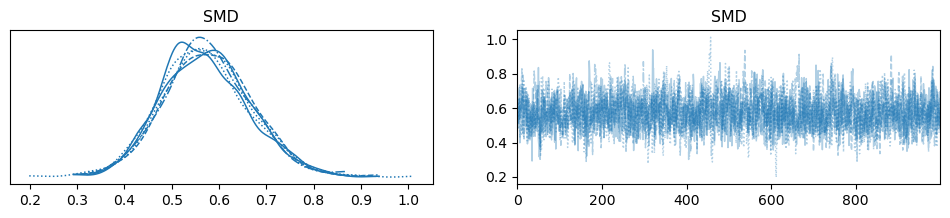

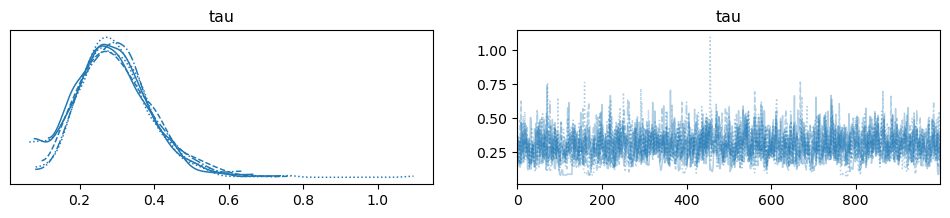

In [10]:
az.plot_trace(trace, var_names="SMD");
az.plot_trace(trace, var_names="tau");

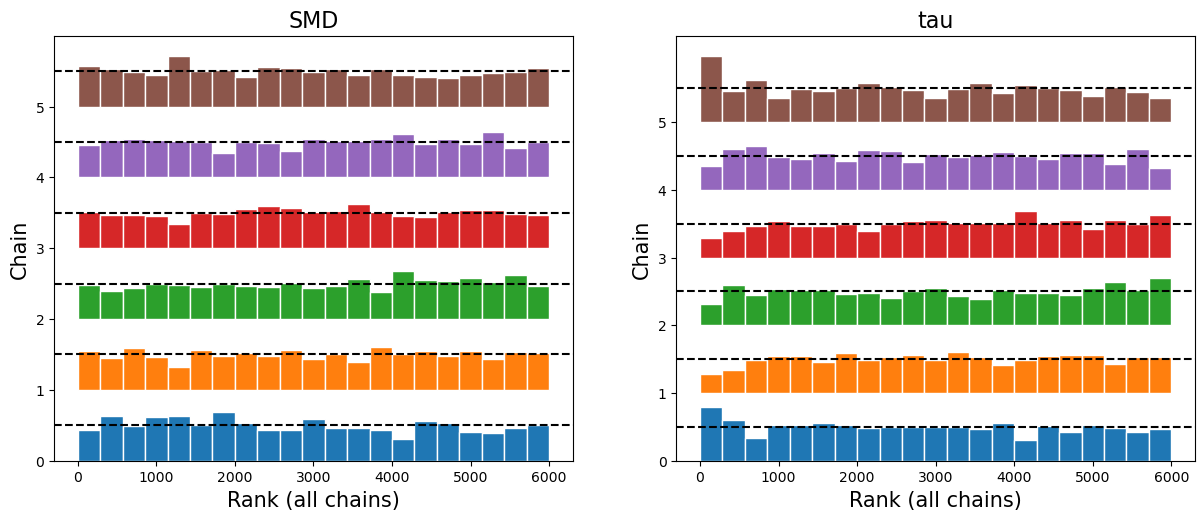

In [20]:
# Rank plot of MCMC chains.
az.plot_rank(trace, var_names=["SMD", "tau"]);

## Posterior predictive check plot

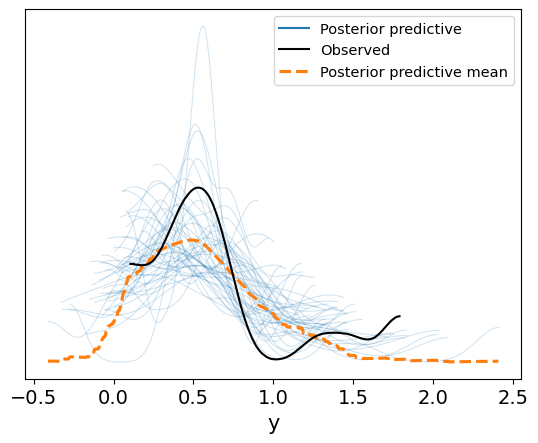

In [15]:
# To coinside with brms output in Harner et al. smaller number of pp samples used than default.
az.plot_ppc(trace, num_pp_samples=50);

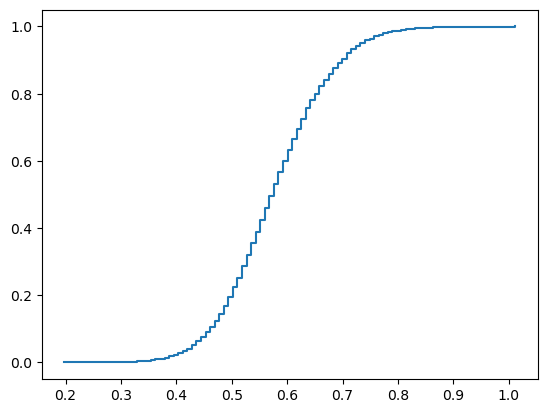

In [31]:
ecdf = az.plot_ecdf(trace.posterior.SMD);
ecdf;

# Interpeting results



# References
Glass, Gene V. 1976. “Primary, Secondary, and Meta-Analysis of Research.” Educational Researcher 5 (10): 3–8.

Harrer, M., Cuijpers, P., Furukawa, T.A., & Ebert, D.D. (2021). Doing Meta-Analysis with R: A Hands-On Guide. Boca Raton, FL and London: Chapmann & Hall/CRC Press. ISBN 978-0-367-61007-4.

Röver, Christian. 2017. “Bayesian Random-Effects Meta-Analysis Using the ‘Bayesmeta‘ r Package.” ArXiv Preprint 1711.08683.

Williams, D. R., Rast, P., & Bürkner, P. C. (2018). Bayesian meta-analysis with weakly informative prior distributions.